In [1]:
%matplotlib inline
%load_ext tensorboard
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import glob
from glob import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
from PIL import Image
# for progress bar
from tqdm import tqdm_notebook, tqdm, trange
#to print multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

# from pytorch_pretrained_vit import ViT

# from linformer import Linformer
from torch.utils.tensorboard import SummaryWriter

In [2]:
'''Helper function to customize/group the data before feeding them into pytorch'''

PATH = "/home/tzortzis/real_data/Downloads/"
EXT = "*.csv"
img_EXT = "*.png"

# test_path = "/home/tzortzis/real_data/Downloads/"
# writer = SummaryWriter("runs/cloth-eff-no-grid-sparse")

'Helper function to customize/group the data before feeding them into pytorch'

In [3]:
all_csv_files = []
all_img_files = []
for path, subdir, files in os.walk(PATH):
    for file in glob(os.path.join(path, EXT)):
        if file.endswith('data.csv'):
            all_csv_files.append(file)
    for i in glob(os.path.join(path, img_EXT)):
        all_img_files.append(i)


li = []

for filename in all_csv_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)



frame = pd.concat(li, axis=0, ignore_index=True)

In [4]:
all_img_files[1]

'/home/tzortzis/real_data/Downloads/white_medium/one_hand_drop/white_medium_one_hand_drop_300085.png'

In [5]:
frame.cloth_state.unique()

array(['flat', 'semi-lifted-onehand', 'semi-lifted-crambled', 'crampled',
       'semi-lifted-twohands', 'lifted', 'folded', 'diagonally Folded',
       'lifted-onehand', 'semi-lifted-twohands-middle'], dtype=object)

In [6]:
state = frame.cloth_state.unique()
state2idx = dict((state,idx) for idx, state in enumerate(state))
idx2state = dict((idx,state) for idx,state in enumerate(state))

In [7]:
frame['label_idx'] = [state2idx[b] for b in frame.cloth_state]
frame.head()

,filename,cloth_state,false_labeling,label_idx
0,white_medium_one_hand_drop_100000,flat,NaN,0
1,white_medium_one_hand_drop_100001,flat,NaN,0
2,white_medium_one_hand_drop_100002,flat,NaN,0
3,white_medium_one_hand_drop_100003,flat,NaN,0
4,white_medium_one_hand_drop_100004,flat,NaN,0


In [8]:
len(frame['label_idx'])

31051

In [9]:
len(state)

10

In [10]:
frame['label_idx'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
class CustomDataset(Dataset):
    def __init__(self, labels_df, img_path, transform=None):
        self.labels_df = labels_df
        self.img_path = img_path
        self.transform = transform
        
        
    def __len__(self):
        return self.labels_df.shape[0]
    
    def __getitem__(self, idx):
        image_name = self.labels_df.filename[idx]
        for file in self.img_path:
            if file.endswith(image_name + '.png'):
                img = Image.open(file)
#                 print(file)
        label = self.labels_df.label_idx[idx]
#         print(file) 
            
        if self.transform:
            img = self.transform(img)

        return img, label

In [12]:
training_dataset = CustomDataset(frame, all_img_files)

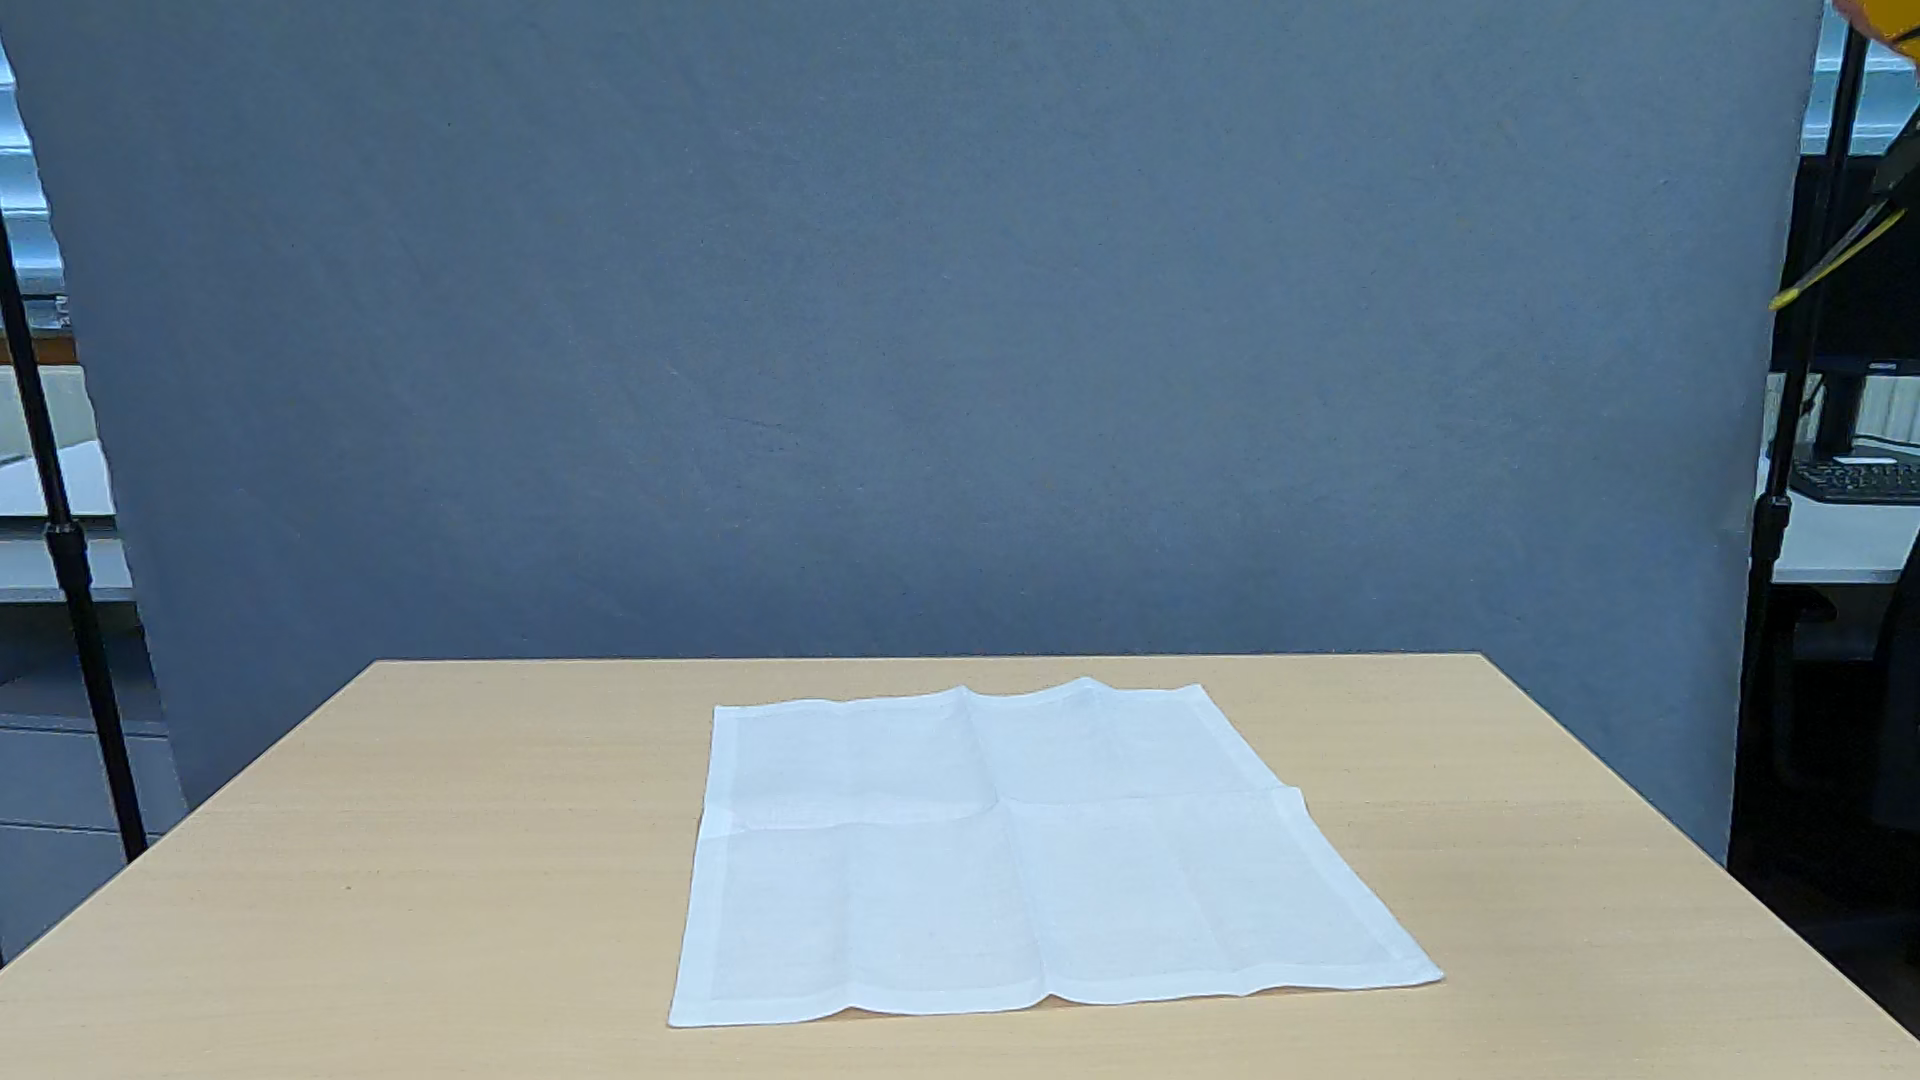

In [13]:
training_dataset[1][0]

In [14]:
input_size = 224
bs = 64

In [15]:
data_transforms = {
    'train': transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#these vectors is the mean and the std from the statistics in imagenet. They are always the same as far as I can recall
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [16]:
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=0)
train_split_idx, val_split_idx = next(iter(stratified_split.split(frame.filename, frame.cloth_state)))
train_df = frame.iloc[train_split_idx].reset_index()
val_df = frame.iloc[val_split_idx].reset_index()

In [17]:
len(train_df), len(val_df)

(24840, 6211)

In [18]:
train_dataset = CustomDataset(train_df, all_img_files, transform=data_transforms['train'])
val_dataset = CustomDataset(val_df, all_img_files, transform=data_transforms['val'])
image_dataset = {'train':train_dataset, 'val':val_dataset}
dataset_names = ['train', 'val']

image_dataloader = {x:DataLoader(image_dataset[x],batch_size=bs,shuffle=True,num_workers=6) for x in dataset_names}
dataset_sizes = {x:len(image_dataset[x]) for x in dataset_names}

In [19]:
val_dataset.labels_df

,index,filename,cloth_state,false_labeling,label_idx
0,4192,orange_one_hand_drop_100128,semi-lifted-crambled,NaN,2
1,26059,rect_white_stripes_one_hand_side_100022,semi-lifted-onehand,NaN,1
2,26757,rect_white_stripes_one_hand_lift_200089,semi-lifted-crambled,NaN,2
3,26306,rect_white_stripes_one_hand_side_200133,folded,NaN,6
4,25311,rect_red_two_hand_side_100070,semi-lifted-twohands,NaN,4
...,...,...,...,...,...
6206,7842,small_green_diag_300032,flat,NaN,0
6207,13385,rect_sparse_stripes_two_hand_side_100091,semi-lifted-twohands,NaN,4
6208,2629,rect_brown_stripes_one_hand_drop_300151,semi-lifted-crambled,NaN,2
6209,7144,small_green_side_200095,folded,NaN,6


In [20]:
def train_model(model, loss_fn, optimizer, scheduler, dataset_sizes, image_dataloader, dataset_names, num_epochs=25):
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    # Each epoch has a training and validation phase
    for epoch in range(num_epochs):
        print('Epoch {0}/{1}'.format(epoch+1, num_epochs), end='\t')

        for phase in dataset_names:
            if phase == 'train':
#                 scheduler.step()
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode


            running_loss = 0.
            running_corrects = 0
            
            # Iterate over data.
            for data in image_dataloader[phase]:
                inps, labels = data
                inps = inps.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inps)
                    _,preds = torch.max(outputs.data,1)
                    loss = loss_fn(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step() #only for onecycle
                    
                # statistics
                running_loss += loss.item() * inps.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
#             writer.add_scalars(phase, {'loss':epoch_loss,
#                                                    'accuracy':epoch_acc},epoch + 1)
            
#             writer.add_scalars(phase, 'accuracy':epoch_acc,epoch + 1)
#             writer.add_scalars(phase, 'loss':epoch_loss,epoch + 1)
            
#             writer.close()
            
            # deep copy model with the best weights
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), "/home/tzortzis/10classes_eff-temp-finetuned.pt")
                
        print()

    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, best_acc.item()

In [21]:
# model_ft = torchvision.models.resnet50(pretrained=True)
from efficientnet_pytorch import EfficientNet
model_ft = EfficientNet.from_pretrained('efficientnet-b0')
# class Model(nn.Module):
#     def __init__(self,eff_name='b0'):
#         super().__init__()
#         self.input = nn.Conv2d(1,3,kernel_size=3,padding=1,stride=2)
#         self.bn = nn.BatchNorm2d(3)
#         self.model_ft = EfficientNet.from_pretrained('efficientnet-b0')
#         self.model_ft._fc = nn.Linear(1536, 500, bias=True)
#         self.meta = nn.Sequential(nn.Linear(4, 500),
#                                   nn.BatchNorm1d(500),
#                                   nn.ReLU(),
#                                   nn.Dropout(p=0.2),
#                                   nn.Linear(500,250),
#                                   nn.BatchNorm1d(250),
#                                   nn.ReLU(),
#                                   nn.Dropout(p=0.2))
#         self.output = nn.Linear(500+250, 10)
#         self.relu = nn.ReLU()
    
#     def forward(self, x,tab):
#         x = self.relu(self.bn(self.input(x)))
#         x = self.model(x)
#         tab = self.meta(tab)
#         x = torch.cat([x, tab],dim=1)
#         return self.output(x)

Loaded pretrained weights for efficientnet-b0


In [22]:
for param in model_ft.parameters():
    param.requires_grad = True    # By doing this I am keeping the parameters of the feature layers frozen so they won't update

num_fc_ftr = model_ft._fc.in_features
model_ft._fc = nn.Sequential(
    nn.Linear(num_fc_ftr, 1000),
    nn.BatchNorm1d(1000),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(1000,500),
    nn.BatchNorm1d(500),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(500,10))

In [23]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam([
#     {'params':model_ft.fc.parameters()}
# ], lr=0.001)
optimizer = optim.SGD(model_ft.parameters(), lr=0.1)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0.01, last_epoch=-1)

# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(image_dataloader['train']), epochs=500, anneal_strategy='cos')

In [24]:
# pytorch_total_params = sum(p.numel() for p in model_ft.fc.parameters() if p.requires_grad)
# pytorch_total_params

In [ ]:
%tensorboard --logdir=runs/cloth-real-20-epochs-eff-no-grid-fine/
model_ft, best_acc = train_model(model_ft,criterion,optimizer,scheduler, dataset_sizes, image_dataloader, dataset_names, num_epochs=20)
# writer.flush()
# writer.close()

Epoch 1/20	

In [ ]:
torch.save(model_ft.state_dict(), "/home/tzortzis/all_real_eff-finetuned-no-flowers.pt")

In [50]:
model_ft.load_state_dict(torch.load('/home/tzortzis/all_real_eff-finetuned.pt'))

<All keys matched successfully>

In [51]:
model_ft.eval()  # it-disables-dropout
from torch.nn import functional as F
import torchvision.transforms.functional as TF


with torch.no_grad():
    correct = 0
    total = 0
    phase = 'val'
    predictions = []
    preds = []
    
    nb_classes = 10

    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    
    for data in image_dataloader['val']:
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
        inps, labels = data
        inps = inps.to(device)
        labels = labels.to(device)
        outputs = model_ft(inps)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        wrong_idx = (predicted != labels.view_as(predicted)).nonzero()[:, 0]
        wrong_samples = inps[wrong_idx]
        wrong_preds = predicted[wrong_idx]
        actual_preds = labels.view_as(predicted)[wrong_idx]
        
        

#         print(val_df.iloc[wrong_idx])
        for i in range(len(wrong_idx)):
            sample = wrong_samples[i]
            wrong_pred = wrong_preds[i]
            actual_pred = actual_preds[i]
            # Undo normalization
            sample = sample * 0.3081
            sample = sample + 0.1307
            sample = sample * 255.
            sample = sample.byte()
            img = TF.to_pil_image(sample)
            img.save('/home/tzortzis/preds/wrong_idx{}_pred{}_actual{}.png'.format(
                wrong_idx[i], wrong_pred.item(), actual_pred.item()))
            print('wrong_idx{}_pred{}_actual{}'.format(wrong_idx[i], wrong_pred.item(), actual_pred.item()))
#             print(val_df.iloc(wrong_idx[i]))
        
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))
#     print('wrong_idx{}_pred{}_actual{}'.format(wrong_idx[i], wrong_pred.item(), actual_pred.item()))

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

/home/tzortzis/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370120218/work/torch/csrc/utils/python_arg_parser.cpp:882.)


wrong_idx48_pred0_actual1
wrong_idx16_pred1_actual2
wrong_idx43_pred6_actual0
wrong_idx52_pred0_actual1
wrong_idx0_pred1_actual0
wrong_idx34_pred1_actual0
wrong_idx63_pred2_actual1
wrong_idx25_pred0_actual1
wrong_idx42_pred1_actual0
wrong_idx45_pred4_actual5
wrong_idx63_pred1_actual0
wrong_idx28_pred1_actual0
wrong_idx36_pred1_actual0
wrong_idx63_pred0_actual4
wrong_idx11_pred1_actual0
wrong_idx43_pred2_actual3
wrong_idx6_pred1_actual6
wrong_idx19_pred1_actual0
wrong_idx41_pred1_actual0
wrong_idx31_pred1_actual0
wrong_idx56_pred1_actual0
wrong_idx28_pred1_actual6
wrong_idx37_pred1_actual6
wrong_idx45_pred0_actual1
wrong_idx32_pred1_actual2
wrong_idx46_pred2_actual8
wrong_idx3_pred1_actual0
wrong_idx18_pred1_actual0
wrong_idx28_pred2_actual1
wrong_idx39_pred4_actual5
wrong_idx10_pred2_actual1
wrong_idx24_pred0_actual1
wrong_idx13_pred1_actual2
wrong_idx4_pred1_actual0
wrong_idx18_pred1_actual0
wrong_idx29_pred1_actual0
wrong_idx27_pred0_actual1
wrong_idx31_pred1_actual0
wrong_idx16_pred

In [53]:
val_df.iloc[22]

index                                 16886
filename          pink_two_hand_lift_100055
cloth_state            semi-lifted-twohands
false_labeling                          NaN
label_idx                                 4
Name: 22, dtype: object

In [ ]:
# import torchvision.transforms.functional as TF

# model_ft.eval()
# test_loss = 0
# correct = 0
# with torch.no_grad():
#     for data, target in image_dataloader['val']:
#         data, target = data.to(device), target.to(device)
#         output = model_ft(data)
#         test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
#         pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#         correct += pred.eq(target.view_as(pred)).sum().item()

#         # Store wrongly predicted images
#         wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
#         wrong_samples = data[wrong_idx]
#         wrong_preds = pred[wrong_idx]
#         actual_preds = target.view_as(pred)[wrong_idx]

#         for i in range(wrong_idx):
#             sample = wrong_samples[i]
#             wrong_pred = wrong_preds[i]
#             actual_pred = actual_preds[i]
#             # Undo normalization
#             sample = sample * 0.3081
#             sample = sample + 0.1307
#             sample = sample * 255.
#             sample = sample.byte()
#             img = TF.to_pil_image(sample)
#             img.save('/home/tzortzis/preds/wrong_idx{}_pred{}_actual{}.png'.format(
#                 wrong_idx[i], wrong_pred.item(), actual_pred.item()))

In [54]:
nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(image_dataloader['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
                

print(confusion_matrix)

tensor([[1.9510e+03, 8.8000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.1000e+01, 1.3910e+03, 1.0000e+01, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+01, 6.7200e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 6.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 3.0000e+00, 2.0800e+02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.8800e+02, 3.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00, 2.4800e+02,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         4.3000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 2.0000

In [55]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([0.9554, 0.9768, 0.9753, 0.9811, 0.9815, 0.9764, 0.9773, 0.9833, 0.9814,
        1.0000])


In [56]:
# cm = confusion_matrix/confusion_matrix.sum(axis=1)
# cm = cm.numpy()
cm = confusion_matrix.numpy()

In [57]:
labels =np.asarray([
    'Flat',
    'Middle grasping with two grippers',
    'Flat semi-lifted with one gripper',
    'Crumpled semi-lifted with one gripper',
    'Crumpled',
    'Lifted with one gripper',
    'Flat semi-lifted with one gripper',
    'Lifted with two grippers',
    'Diagonally Folded',
     'Sideways Folded'])

<AxesSubplot:>

Text(68.99999999999999, 0.5, 'Actual')

Text(0.5, 69.0, 'Predicted')

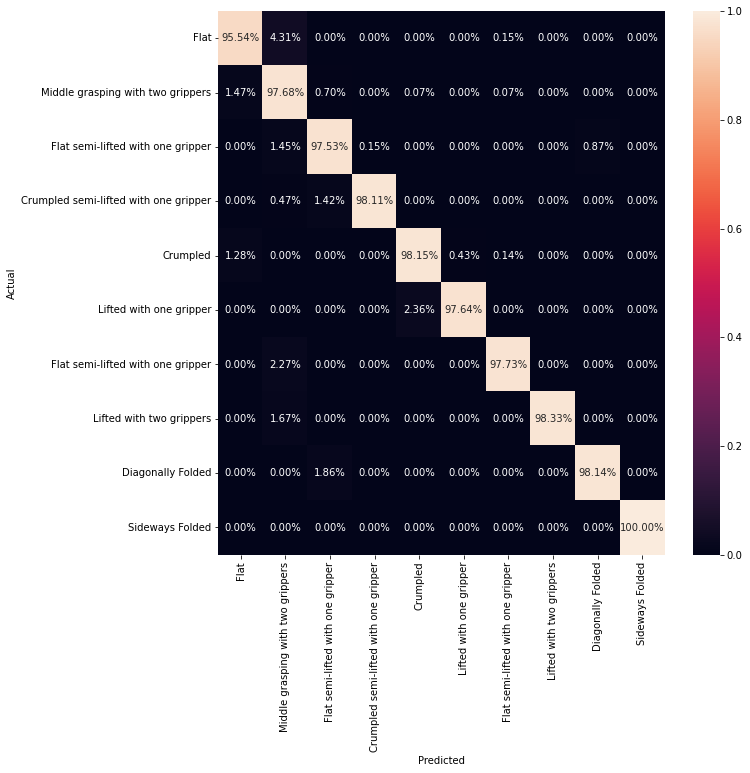

In [58]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2%', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
# plt.figure(figsize=(16, 6))
# sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

In [59]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cmn, annot=labels, fmt='', cmap='Blues')

ValueError: `data` and `annot` must have same shape.

In [ ]:
tensor([[521.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 178.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0., 513.,   3.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   3.,  54.,   0.,   1.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,  87.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   2.,   0.,   0.,  44.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0., 148.,   1.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   1., 164.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 162.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 358.]])

tensor([1.0000, 1.0000, 0.9942, 0.9430, 1.0000, 0.9639, 0.9954, 0.9933, 1.0000,
        1.0000])

99.51
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

tensor([[4.3060e+03, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.2430e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [6.0000e+00, 0.0000e+00, 4.0890e+03, 2.6000e+01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.8000e+01, 5.1700e+02, 0.0000e+00, 9.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.2700e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 6.0000e+00, 1.0000e+01, 0.0000e+00, 4.8200e+02,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.2860e+03, 5.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.0000e+00, 1.4950e+03, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.3700e+03, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6770e+03]])

tensor([0.9995, 1.0000, 0.9922, 0.9504, 1.0000, 0.9679, 0.9961, 0.9987, 1.0000,
        1.0000])

99.54

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

99.54

tensor([[4.3080e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.2430e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 0.0000e+00, 4.0880e+03, 3.1000e+01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 8.0000e+00, 5.2200e+02, 0.0000e+00, 1.4000e+01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.2700e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 6.0000e+00, 6.0000e+00, 0.0000e+00, 4.8600e+02,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.2750e+03, 1.6000e+01, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.4970e+03, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.3700e+03, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6770e+03]])


tensor([1.0000, 1.0000, 0.9920, 0.9596, 1.0000, 0.9759, 0.9876, 1.0000, 1.0000,
        1.0000])

